# Setup

In [1]:
from pathlib import Path

import confuse
import pandas

from classifier import DialogueActClassifierFactory

cfg = confuse.LazyConfig('ccc4prc', __name__)
# Add overrides on top of config.yaml for the workspace.
cfg.set_file('./config.workspace.yaml')

dac_factory = DialogueActClassifierFactory()
dac_labels = dac_factory.get_classifier(
    Path(cfg['dialogue_act_classification']['classifier_file'].as_filename()),
    cfg['dialogue_act_classification']['test_set_percentage'].as_number()).labels()

dataset_dir = Path(cfg['machine_learning']['labeled_seed_excel_file'].as_filename()).parent
training_dataset_file = dataset_dir / ('training_dataset.csv')
test_dataset_file = dataset_dir / ('test_dataset.csv')

training_dataset = pandas.read_csv(training_dataset_file)
test_dataset = pandas.read_csv(test_dataset_file)

In [2]:
from array import array
from pathlib import Path

import numpy
import pandas
from matplotlib import pyplot
from pandas import DataFrame
from sklearn import metrics

FEATURES = ['body', 'dialogue_act_classification_ml', 'comment_is_by_author']
LABEL = 'code_comprehension_related'
report_dict_list = []

# Dialogue Act Classifier Performance

In [3]:
from collections import defaultdict

precisions, recalls = dac_factory.get_precision_and_recall()
precisions_recalls = [precisions, recalls]

dac_report = {}
dac_report[''] = [None, None, dac_factory.get_accuracy()]
for label in precisions.keys():
  dac_report[label] = [i[label] for i in precisions_recalls]

df = DataFrame.from_dict(dac_report, orient='index', columns=['Precision', 'Recall', 'Accuracy'])

df

,Precision,Recall,Accuracy
,NaN,NaN,0.666667
Statement,0.666667,0.593023,NaN
Emotion,0.989247,0.666667,NaN
System,0.951456,0.911628,NaN
Greet,1.000000,0.804878,NaN
Accept,0.615385,0.216216,NaN
Reject,0.157895,0.166667,NaN
whQuestion,0.746269,0.769231,NaN
Continuer,0.000000,0.000000,NaN
ynQuestion,0.671429,0.734375,NaN


# Original Classifier Model Performance

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

one_hot_encoder_categories = [
    dac_labels,
    [
        False,  # 0 should come before 1 for numerical columns.
        True
    ]
]

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_pipeline', CountVectorizer(stop_words='english'), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_pipeline': 1.0,
        'categorical_transformer': 1.0,
    },
    verbose=False)

clf_original = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', probability=True))],
    verbose=False)

X_train = training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train = training_dataset[LABEL]
y_true = test_dataset[LABEL]

clf_original.fit(X_train, y_train)
y_pred = clf_original.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'Original (CountVectorizer)': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.86086957 0.94285714 0.90000000       315
         Yes  0.55000000 0.31428571 0.40000000        70

    accuracy                      0.82857143       385
   macro avg  0.70543478 0.62857143 0.65000000       385
weighted avg  0.80434783 0.82857143 0.80909091       385



# Evenly distribute the training data labelled as "No" and "Yes".

In [5]:
min_label_count = y_train.value_counts().min()
labelled_yes = training_dataset.loc[training_dataset[LABEL] == 'Yes'].head(min_label_count)
labelled_no = training_dataset.loc[training_dataset[LABEL] == 'No'].head(min_label_count)
evenly_distrubted_training_dataset = pandas.concat([labelled_yes, labelled_no])

# Shuffle the order, in order to properly train the model.
evenly_distrubted_training_dataset = evenly_distrubted_training_dataset.sample(frac=1)

# Show the datasets value counts
print(f'Training DataSet - Label "Yes": {len(training_dataset.loc[training_dataset[LABEL] == "Yes"])} v.s. "No": {len(training_dataset.loc[training_dataset[LABEL] == "No"])}, ratio: {len(training_dataset.loc[training_dataset[LABEL] == "Yes"])/len(training_dataset.loc[training_dataset[LABEL] == "No"])}')
print(f'Test Dataset - Label "Yes": {len(test_dataset.loc[test_dataset[LABEL] == "Yes"])} v.s. "No": {len(test_dataset.loc[test_dataset[LABEL] == "No"])}, ratio: {len(test_dataset.loc[test_dataset[LABEL] == "Yes"])/len(test_dataset.loc[test_dataset[LABEL] == "No"])}')
print(f'Training DataSet (evenly distributed) - Label "Yes": {len(evenly_distrubted_training_dataset.loc[evenly_distrubted_training_dataset[LABEL] == "Yes"])} v.s. "No": {len(evenly_distrubted_training_dataset.loc[evenly_distrubted_training_dataset[LABEL] == "No"])}')

Training DataSet - Label "Yes": 75 v.s. "No": 310, ratio: 0.24193548387096775
Test Dataset - Label "Yes": 70 v.s. "No": 315, ratio: 0.2222222222222222
Training DataSet (evenly distributed) - Label "Yes": 75 v.s. "No": 75


In [6]:
# Performance after evenly distributed only the training dataset with labels "No" and "Yes".
X_train_evenly_distributed = evenly_distrubted_training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train_evenly_distributed = evenly_distrubted_training_dataset[LABEL]
y_true = test_dataset[LABEL]

clf_original.fit(X_train_evenly_distributed, y_train_evenly_distributed)
y_pred = clf_original.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'Original (CountVectorizer + Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.90825688 0.62857143 0.74296435       315
         Yes  0.29940120 0.71428571 0.42194093        70

    accuracy                      0.64415584       385
   macro avg  0.60382904 0.67142857 0.58245264       385
weighted avg  0.79755585 0.64415584 0.68459646       385



In [7]:
%%script false --no-raise-error
# Performance after evenly distributed both the training and test datasets with labels "No" and "Yes".
# But in practice, the incoming data is likely to be skewed to "No", so this is experiment only.
# Evenly distribute the test data labelled as "No" and "Yes".
min_label_count = y_true.value_counts().min()
labelled_yes = test_dataset.loc[test_dataset[LABEL] == 'Yes'].head(min_label_count)
labelled_no = test_dataset.loc[test_dataset[LABEL] == 'No'].head(min_label_count)
evenly_distrubted_test_dataset = pandas.concat([labelled_yes, labelled_no])

X_train = evenly_distrubted_training_dataset[FEATURES]
X_test = evenly_distrubted_test_dataset[FEATURES]
y_train = evenly_distrubted_training_dataset[LABEL]
y_true = evenly_distrubted_test_dataset[LABEL]

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)

# Tuning - using a different vectorization - TDIDF

In [8]:
# Setup
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

X_train = training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train = training_dataset[LABEL]
y_true = test_dataset[LABEL]

# X_train = evenly_distrubted_training_dataset[FEATURES]
# X_test = test_dataset[FEATURES]
# y_train = evenly_distrubted_training_dataset[LABEL]
# y_true = test_dataset[LABEL]

In [9]:
column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
        # ('author_transformer', OneHotEncoder(categories=[[False, True]]), ['comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 3,
        'categorical_transformer': 1,
        # 'author_transformer': 0,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'TDIDF': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.84054054 0.98730159 0.90802920       315
         Yes  0.73333333 0.15714286 0.25882353        70

    accuracy                      0.83636364       385
   macro avg  0.78693694 0.57222222 0.58342636       385
weighted avg  0.82104832 0.83636364 0.78999180       385



# Tuning - add Stemming

In [10]:
from nltk.stem.snowball import SnowballStemmer

class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english', ignore_stopwords=True)
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', StemmedCountVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 3,
        'categorical_transformer': 1,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'TDIDF+Stemming': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.84054054 0.98730159 0.90802920       315
         Yes  0.73333333 0.15714286 0.25882353        70

    accuracy                      0.83636364       385
   macro avg  0.78693694 0.57222222 0.58342636       385
weighted avg  0.82104832 0.83636364 0.78999180       385



# Tuning - try adding Lemmatization

In [11]:
from nlp import LemmaTokenizer

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', ngram_range=(1, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 4,
        'categorical_transformer': 1,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=0.1, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'TDIDF+Lemmatization': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.92546584 0.94603175 0.93563579       315
         Yes  0.73015873 0.65714286 0.69172932        70

    accuracy                      0.89350649       385
   macro avg  0.82781228 0.80158730 0.81368256       385
weighted avg  0.88995546 0.89350649 0.89128916       385



# Tuning - try using MultinominalNB

In [12]:
from sklearn.naive_bayes import MultinomialNB

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 3,
        'categorical_transformer': 1,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', MultinomialNB(fit_prior=True))],
    verbose=False)

clf_multinominal_nb = full_pipeline

clf_multinominal_nb.fit(X_train, y_train)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'MultinomialNB': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.82849604 0.99682540 0.90489914       315
         Yes  0.83333333 0.07142857 0.13157895        70

    accuracy                      0.82857143       385
   macro avg  0.83091469 0.53412698 0.51823904       385
weighted avg  0.82937555 0.82857143 0.76429546       385



# Tuning - try using Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 3,
        'categorical_transformer': 1,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', LogisticRegression())],
    verbose=False)

clf_logistic_regression = full_pipeline

clf_logistic_regression.fit(X_train, y_train)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'LogisticRegression': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.83510638 0.99682540 0.90882779       315
         Yes  0.88888889 0.11428571 0.20253165        70

    accuracy                      0.83636364       385
   macro avg  0.86199764 0.55555556 0.55567972       385
weighted avg  0.84488502 0.83636364 0.78041031       385



# Tuning - try using Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 3,
        'categorical_transformer': 1,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', DecisionTreeClassifier())],
    verbose=False)

clf_decision_treee = full_pipeline

clf_decision_treee.fit(X_train, y_train)
y_pred = clf_decision_treee.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'DecisionTree': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.84615385 0.90793651 0.87595712       315
         Yes  0.38297872 0.25714286 0.30769231        70

    accuracy                      0.78961039       385
   macro avg  0.61456628 0.58253968 0.59182471       385
weighted avg  0.76194019 0.78961039 0.77263625       385



# Tuning the model with Grid Search

In [15]:
column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=None, ngram_range=(1, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 1,
        'categorical_transformer': 3,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

scorer = metrics.make_scorer(metrics.precision_score, pos_label="Yes")

grid_search_cv_params = [
    {
        'preprocessor__transformer_weights': [
            {'body_bow_vectorizer': 1, 'categorical_transformer': 1},
            {'body_bow_vectorizer': 1, 'categorical_transformer': 4},
            {'body_bow_vectorizer': 1, 'categorical_transformer': 6},
            {'body_bow_vectorizer': 1, 'categorical_transformer': 10},
            {'body_bow_vectorizer': 2, 'categorical_transformer': 1},
            {'body_bow_vectorizer': 4, 'categorical_transformer': 1},
            {'body_bow_vectorizer': 6, 'categorical_transformer': 1},
            {'body_bow_vectorizer': 10, 'categorical_transformer': 1},                                      
        ]
    },
    {'preprocessor__body_bow_vectorizer__stop_words': [None, 'english']},
    {'preprocessor__body_bow_vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 5), (2, 2), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5)]},
    {'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
    {'classifier__C': [0.8, 1, 1.2, 2, 4]},    
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring='accuracy')

clf_grid_search_cv.fit(X_train, y_train)
clf_grid_search_cv.best_params_

{'classifier__C': 1}

In [16]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'TDIDF+GridSearch': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.87572254 0.96190476 0.91679274       315
         Yes  0.69230769 0.38571429 0.49541284        70

    accuracy                      0.85714286       385
   macro avg  0.78401512 0.67380952 0.70610279       385
weighted avg  0.84237439 0.85714286 0.84017821       385



# Optimal Algorithm

In [17]:
from classifier import CodeComprehensionClassifierFactory

clf_optimal = CodeComprehensionClassifierFactory.get_classifier(dac_labels)

clf_optimal.fit(X_train, y_train)
y_pred = clf_optimal.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'CodeComprehensionClassifierFactory': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.91717791 0.94920635 0.93291732       315
         Yes  0.72881356 0.61428571 0.66666667        70

    accuracy                      0.88831169       385
   macro avg  0.82299574 0.78174603 0.79979199       385
weighted avg  0.88292985 0.88831169 0.88450811       385



# Performance Result Comparison

In [18]:
from matplotlib import pyplot

x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

df

,Algorithms,no_precision,no_recall,no_f1_score,yes_precision,yes_recall,yes_f1_score,Accuracy
0,Original (CountVectorizer),0.860870,0.942857,0.900000,0.550000,0.314286,0.400000,0.828571
1,Original (CountVectorizer + Evenly Distributed),0.908257,0.628571,0.742964,0.299401,0.714286,0.421941,0.644156
2,TDIDF,0.840541,0.987302,0.908029,0.733333,0.157143,0.258824,0.836364
3,TDIDF+Stemming,0.840541,0.987302,0.908029,0.733333,0.157143,0.258824,0.836364
4,TDIDF+Lemmatization,0.925466,0.946032,0.935636,0.730159,0.657143,0.691729,0.893506
5,MultinomialNB,0.828496,0.996825,0.904899,0.833333,0.071429,0.131579,0.828571
6,LogisticRegression,0.835106,0.996825,0.908828,0.888889,0.114286,0.202532,0.836364
7,DecisionTree,0.846154,0.907937,0.875957,0.382979,0.257143,0.307692,0.789610
8,TDIDF+GridSearch,0.875723,0.961905,0.916793,0.692308,0.385714,0.495413,0.857143
9,CodeComprehensionClassifierFactory,0.917178,0.949206,0.932917,0.728814,0.614286,0.666667,0.888312


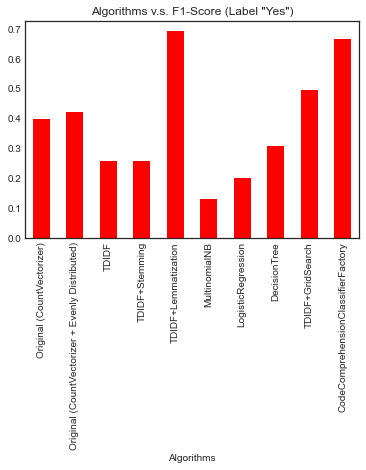

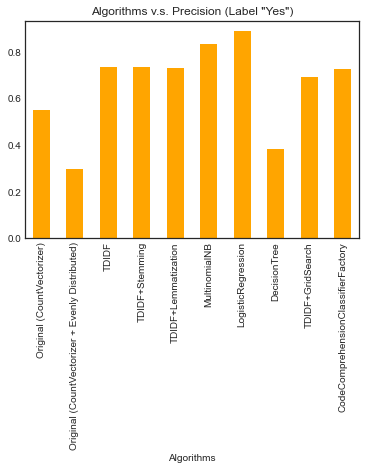

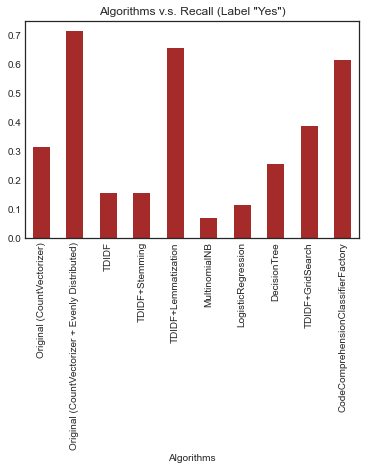

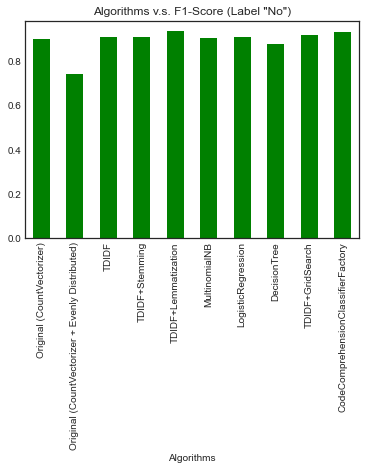

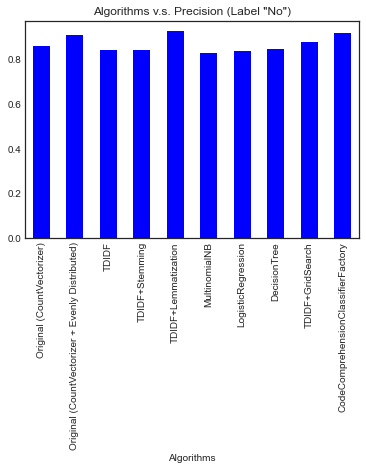

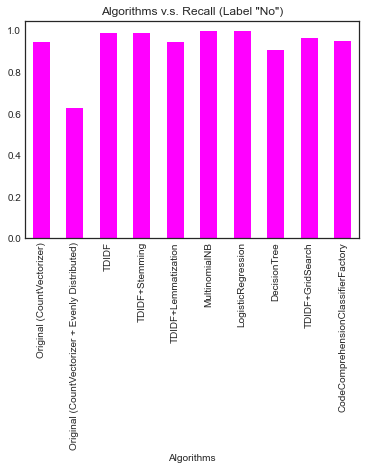

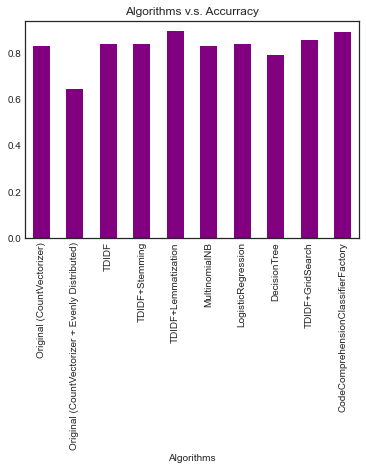

In [19]:
with pyplot.style.context('seaborn-white'):
    df.plot.bar(x='Algorithms', y='yes_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "Yes")', color='red', legend=False)
    df.plot.bar(x='Algorithms', y='yes_precision', rot=90, title='Algorithms v.s. Precision (Label "Yes")', color='orange', legend=False)
    df.plot.bar(x='Algorithms', y='yes_recall', rot=90, title='Algorithms v.s. Recall (Label "Yes")', color='brown', legend=False)
    df.plot.bar(x='Algorithms', y='no_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "No")', color='green', legend=False)
    df.plot.bar(x='Algorithms', y='no_precision', rot=90, title='Algorithms v.s. Precision (Label "No")', color='blue', legend=False)
    df.plot.bar(x='Algorithms', y='no_recall', rot=90, title='Algorithms v.s. Recall (Label "No")', color='magenta', legend=False)
    df.plot.bar(x='Algorithms', y='Accuracy', rot=90, title='Algorithms v.s. Accurracy', color='purple', legend=False)

    # axes = df.plot.bar(rot=90, title="Algorithms Performance", subplots=True)

    pyplot.show(block=False)